## Two-Qubit Kitaev Chain Simulation: Trotterized Time Evolution

This notebook simulates **time evolution** under a 2-site **Kitaev chain** model using **first-order Trotterization**.

### Physical Model

We study the Kitaev chain:
\\[
H = -\mu (c_0^\dagger c_0 + c_1^\dagger c_1) 
    - t (c_0^\dagger c_1 + \text{h.c.}) 
    + \Delta (c_0 c_1 + \text{h.c.})
\\]

Using the **Jordan–Wigner transformation**, we map this fermionic model to a qubit Hamiltonian:
\\[
H = -\frac{\mu}{2}(Z_0 + Z_1)
    - \frac{t}{2}(X_0 X_1 + Y_0 Y_1)
    + \frac{\Delta}{2}(Y_0 X_1 - X_0 Y_1)
\\]

This model captures **hopping** and **p-wave pairing** between two fermionic sites, and is foundational in the study of **topological superconductivity** and **Majorana modes**.

### Simulation Goals

- Implement the qubit Hamiltonian in Qiskit
- Construct a **Trotterized time evolution operator** \\( e^{-i H t} \\)
- Initialize the state in \\(|++⟩\\) and evolve it forward in time
- Visualize the quantum circuit

### Technical Ingredients

- `SparsePauliOp` to build the Hamiltonian
- `PauliEvolutionGate` for simulating \\( e^{-i H t} \\)
- `QuantumCircuit` to initialize, evolve, and measure the state

---

This simulation provides a foundation for exploring dynamics in topological quantum systems using quantum circuits.


In [15]:
"""
Two-Qubit Kitaev Chain: Trotterized Time Evolution (Step-by-Step Review)

This code implements the Trotterized evolution of a 2-qubit Kitaev chain model,
following its Jordan-Wigner transformation into Pauli terms.
We use Qiskit to construct the Hamiltonian and build a quantum circuit.
"""

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
import numpy as np

# ----------------------------------------
# 1. Model Parameters
# ----------------------------------------
mu = 1.0      # Chemical potential
t = 1.0       # Hopping amplitude
delta = 1.0   # Superconducting pairing strength
dt = 0.1      # Time step for Trotterized evolution

# ----------------------------------------
# 2. Define Kitaev Hamiltonian (mapped to qubits)
# ----------------------------------------
# Jordan–Wigner transformed 2-site Kitaev Hamiltonian:
# H = -mu/2 * (Z_0 + Z_1)
#   -t/2 * (X_0 X_1 + Y_0 Y_1)
#   +delta/2 * (Y_0 X_1 - X_0 Y_1)

paulis = [
    ("Z", -mu/2),    # Z0 term (site 0 occupation)
    ("IZ", -mu/2),   # Z1 term (site 1 occupation)
    ("XX", -t/2),    # Hopping: X0 X1
    ("YY", -t/2),    # Hopping: Y0 Y1
    ("YX", delta/2), # Pairing: Y0 X1
    ("XY", -delta/2) # Pairing: -X0 Y1
]

# Ensure each label is 2-qubit long
full_terms = []
for label, coeff in paulis:
    if len(label) == 1:
        full_label = label + "I"  # Pad with identity on second qubit
    else:
        full_label = label
    full_terms.append((full_label, coeff))

# ----------------------------------------
# 3. Create SparsePauliOp for the Hamiltonian
# ----------------------------------------
labels, coeffs = zip(*full_terms)
hamiltonian = SparsePauliOp.from_list(list(zip(labels, coeffs)))

# ----------------------------------------
# 4. Construct Trotterized Evolution Gate
# ----------------------------------------
evolution_gate = PauliEvolutionGate(
    hamiltonian, time=dt, synthesis="trotter"  # Use first-order Trotter decomposition
)

# ----------------------------------------
# 5. Build and Initialize Quantum Circuit
# ----------------------------------------
qc = QuantumCircuit(2)
qc.h([0, 1])  # Prepare initial state |++> (equal superposition of all basis states)
qc.append(evolution_gate, [0, 1])  # Apply time evolution operator
qc.measure_all()  # Add measurements to readout final state

# ----------------------------------------
# 6. Visualize the Circuit
# ----------------------------------------
print(qc.draw())


        ┌───┐┌──────────────────────────────────────────────┐ ░ ┌─┐   
   q_0: ┤ H ├┤0                                             ├─░─┤M├───
        ├───┤│  exp(-it (ZI + IZ + XX + YY + YX + XY))(0.1) │ ░ └╥┘┌─┐
   q_1: ┤ H ├┤1                                             ├─░──╫─┤M├
        └───┘└──────────────────────────────────────────────┘ ░  ║ └╥┘
meas: 2/═════════════════════════════════════════════════════════╩══╩═
                                                                 0  1 


## Tracking Observable Dynamics in the 2-Qubit Kitaev Chain

This section extends the simulation of the Kitaev chain by repeatedly applying the **Trotterized time evolution operator** and computing key **physical observables** at each time step.

### Key Objectives:

- Simulate the evolution of a 2-site Kitaev chain under its qubit-mapped Hamiltonian
- Start from an initial coherent state \(|++⟩\)
- Apply **first-order Trotterized evolution** repeatedly for a total of `steps × dt` units of time
- Monitor the evolution of important observables:
  - ⟨Z₀⟩: site 0 occupation
  - ⟨Z₁⟩: site 1 occupation
  - ⟨X₀X₁⟩: coherence/correlation between the sites

### What’s New in This Section?

- **Repeated evolution:** Applies the time-evolution operator in a loop to simulate dynamics across a time window.
- **Expectation value tracking:** Uses Qiskit’s `Statevector.expectation_value` to compute ⟨O⟩ for selected Pauli operators.
- **Visualization:** Plots how local site occupations and two-qubit coherence evolve over time.

### Physical Insight:

By tracking ⟨Z⟩ and ⟨X₀X₁⟩, we learn how:
- Quantum information spreads between the two sites
- The system builds or loses coherence over time
- The balance between hopping and pairing influences local and nonlocal observables

---

This time-domain simulation gives you a direct view into the **unitary dynamics** of a minimal quantum superconducting system.
c

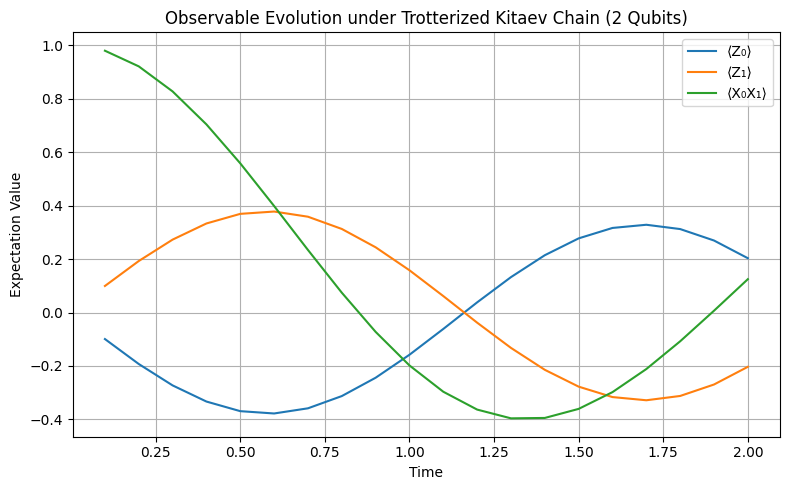

In [17]:
"""
Simulating Time Evolution in a 2-Qubit Kitaev Chain using Trotterization

This script simulates the Trotterized time evolution of a 2-site Kitaev chain
(topological superconducting model) mapped onto qubits via the Jordan–Wigner
transformation. It uses Qiskit's `PauliEvolutionGate` with a sparse Pauli Hamiltonian.

We evolve the initial state |++⟩ and track key observable expectation values over time:
    - ⟨Z₀⟩: Site 0 occupation
    - ⟨Z₁⟩: Site 1 occupation
    - ⟨X₀X₁⟩: Two-site coherence

The evolution is simulated using the `Statevector` simulator (no noise).
"""

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp, Pauli
from qiskit.circuit.library import PauliEvolutionGate
import matplotlib.pyplot as plt

# ----------------------------
# System and simulation parameters
# ----------------------------

mu = 1.0      # Chemical potential
t = 1.0       # Hopping amplitude
delta = 1.0   # Superconducting pairing strength
dt = 0.1      # Trotter step size
steps = 20    # Number of Trotter steps (total time = steps × dt)

# ----------------------------
# Define the 2-qubit Hamiltonian
# ----------------------------
# Kitaev Hamiltonian in Pauli operator form after Jordan-Wigner transformation:
# H = -mu/2 (Z0 + Z1)
#   -t/2 (X0X1 + Y0Y1)
#   +Δ/2 (Y0X1 - X0Y1)

paulis = [
    ("Z", -mu/2),   # Z0
    ("IZ", -mu/2),  # Z1
    ("XX", -t/2),   # hopping term
    ("YY", -t/2),   # hopping term
    ("YX", delta/2),   # pairing term
    ("XY", -delta/2)   # pairing term
]

# Normalize all Pauli labels to 2-qubit strings (e.g., "Z" → "ZI")
terms = [(p if len(p) == 2 else p + "I", c) for p, c in paulis]

# Extract labels and coefficients
labels, coeffs = zip(*terms)

# Create the sparse Pauli representation of the Hamiltonian
H = SparsePauliOp.from_list(list(zip(labels, coeffs)))

# Build the Trotterized time-evolution operator U(dt) = exp(-iH·dt)
U = PauliEvolutionGate(H, time=dt)

# ----------------------------
# Initial State: |++⟩ = H|00⟩
# ----------------------------
qc_init = QuantumCircuit(2)
qc_init.h([0, 1])  # Apply Hadamard to both qubits
state = Statevector.from_instruction(qc_init)

# ----------------------------
# Define observables to track over time
# ----------------------------
observables = {
    "⟨Z₀⟩": Pauli("ZI"),     # Site 0 density
    "⟨Z₁⟩": Pauli("IZ"),     # Site 1 density
    "⟨X₀X₁⟩": Pauli("XX")    # Coherence between sites
}

# Initialize results container
results = {name: [] for name in observables}
times = []

# ----------------------------
# Perform Trotterized Time Evolution
# ----------------------------
for step in range(steps):
    # Create a circuit for one Trotter step
    qc_step = QuantumCircuit(2)
    qc_step.append(U, [0, 1])
    
    # Evolve the current state
    state = state.evolve(qc_step)
    
    # Measure expectation values of observables
    for name, op in observables.items():
        results[name].append(np.real(state.expectation_value(op)))
    
    # Track simulation time
    times.append((step + 1) * dt)

# ----------------------------
# Plotting the Observables Over Time
# ----------------------------
plt.figure(figsize=(8, 5))
for name, values in results.items():
    plt.plot(times, values, label=name)
plt.xlabel("Time")
plt.ylabel("Expectation Value")
plt.title("Observable Evolution under Trotterized Kitaev Chain (2 Qubits)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation of Observable Evolution

The plot shows the time evolution of key observables under Trotterized dynamics of a 2-site Kitaev chain:

- **⟨Z₀⟩ and ⟨Z₁⟩ (blue and orange curves):**  
  These represent the occupation (number) operators for site 0 and site 1, respectively. Initially, both qubits are in a superposition state |+⟩, leading to partial occupation. Over time, ⟨Z₀⟩ and ⟨Z₁⟩ oscillate out of phase due to coherent tunneling and pairing dynamics between the two sites.

- **⟨X₀X₁⟩ (green curve):**  
  This term captures the **coherence and correlation** between the two sites in the \(X\)-basis. It starts close to 1 because the initial state is |++⟩ (fully coherent in \(X\)), and gradually decays and oscillates as interactions evolve the system away from this initial configuration.

---

### Physical Insight

- The oscillatory behavior is a hallmark of **unitary coherent dynamics** driven by the Hamiltonian.
- The asymmetry between ⟨Z₀⟩ and ⟨Z₁⟩ shows how the system's topology and interaction (especially the pairing term) drive **site-resolved dynamics**.
- The decay and revival of ⟨X₀X₁⟩ indicates periodic coherence loss and partial revival—a signature of **quantum correlations** modulated by pairing interactions.

This simulation confirms that the 2-site Kitaev model exhibits rich quantum dynamics even in the minimal case, and serves as a stepping stone for scaling up to larger chains or exploring topological signatures.

---
---

### Connection to Majorana Physics and Topological Superconductivity

The 2-site Kitaev chain is a minimal building block of the full 1D **Kitaev model**, which is known to support **topological superconductivity** and **Majorana zero modes** at its boundaries in the thermodynamic limit.

#### How This 2-Qubit Simulation Relates to the Full Kitaev Chain:

- In the full Kitaev chain:
  - Fermionic sites are coupled via hopping and **p-wave pairing** terms.
  - When the system is in the **topological phase** (typically for \( |\mu| < 2t \)), **unpaired Majorana modes** emerge at the edges of the chain.
  - These edge modes are robust to local perturbations and have potential use in **topological quantum computation**.

- In our 2-qubit system:
  - The pairing terms \( Y_0 X_1 - X_0 Y_1 \) mimic the **non-local correlations** that arise from Majorana mode interference.
  - The oscillations in ⟨Z₀⟩ and ⟨Z₁⟩ are signatures of **delocalized fermionic occupation**, which, in a longer chain, would evolve into edge-localized Majorana modes.
  - The observable ⟨X₀X₁⟩ serves as a probe of coherence and can be related to **nonlocal fermion parity measurements**.

#### Toward a Topological Phase:
To fully realize Majorana edge physics, this simulation can be extended by:
- Scaling up to **larger qubit chains** (≥4 qubits).
- Tracking **string operators** or **nonlocal parity correlations**.
- Measuring **entanglement entropy growth** or **spectral signatures** (e.g., zero-energy modes).

---

**Big Picture**:  
This 2-qubit simulation captures the **core building blocks** of a topological quantum wire. It forms a conceptual and computational foundation for exploring topological protection, entanglement, and exotic quasiparticles like Majorana fermions using quantum hardware.


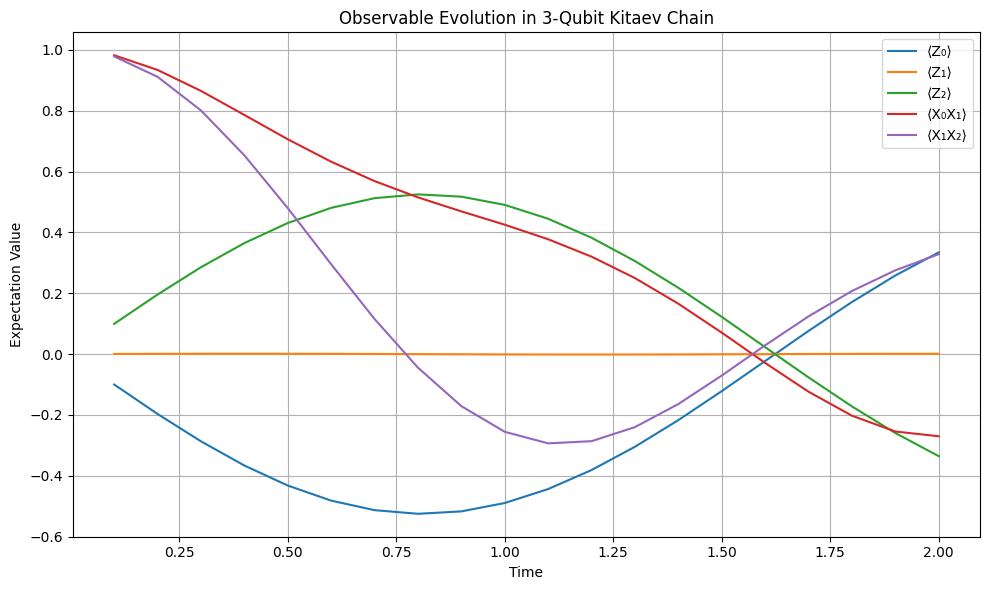

In [6]:
"""
3-Qubit Kitaev Chain Simulation using Trotterized Time Evolution

This notebook simulates the time evolution of a 3-site Kitaev chain under a mapped qubit Hamiltonian
(using the Jordan-Wigner transformation). The simulation is performed using Qiskit's statevector simulator.

We track the evolution of observables such as site occupations and two-site correlations under
first-order Trotterized evolution.
"""

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp, Pauli
from qiskit.circuit.library import PauliEvolutionGate
import matplotlib.pyplot as plt

# ----------------------------
# Parameters
# ----------------------------
mu = 1.0      # Chemical potential
t = 1.0       # Hopping amplitude
delta = 1.0   # Superconducting pairing strength
dt = 0.1      # Trotter step size
steps = 20    # Number of Trotter steps

# ----------------------------
# Define the 3-site Kitaev Hamiltonian (Jordan–Wigner transformed)
# ----------------------------
pauli_terms = []

# Number terms: -mu/2 * (Z0 + Z1 + Z2)
for i in range(3):
    label = ['I'] * 3
    label[i] = 'Z'
    pauli_terms.append((''.join(label), -mu / 2))

# Hopping terms: -t/2 * (X_i X_{i+1} + Y_i Y_{i+1})
for i in range(2):
    label_xx = ['I'] * 3
    label_yy = ['I'] * 3
    label_xx[i] = 'X'
    label_xx[i+1] = 'X'
    label_yy[i] = 'Y'
    label_yy[i+1] = 'Y'
    pauli_terms.append((''.join(label_xx), -t/2))
    pauli_terms.append((''.join(label_yy), -t/2))

# Pairing terms: +delta/2 * (Y_i X_{i+1} - X_i Y_{i+1})
for i in range(2):
    label_yx = ['I'] * 3
    label_xy = ['I'] * 3
    label_yx[i] = 'Y'
    label_yx[i+1] = 'X'
    label_xy[i] = 'X'
    label_xy[i+1] = 'Y'
    pauli_terms.append((''.join(label_yx), delta/2))
    pauli_terms.append((''.join(label_xy), -delta/2))

# Create SparsePauliOp Hamiltonian
H = SparsePauliOp.from_list(pauli_terms)
U = PauliEvolutionGate(H, time=dt)

# ----------------------------
# Initial State: |+++>
# ----------------------------
qc_init = QuantumCircuit(3)
qc_init.h([0, 1, 2])
state = Statevector.from_instruction(qc_init)

# ----------------------------
# Observables to track
# ----------------------------
observables = {
    "⟨Z₀⟩": Pauli("ZII"),
    "⟨Z₁⟩": Pauli("IZI"),
    "⟨Z₂⟩": Pauli("IIZ"),
    "⟨X₀X₁⟩": Pauli("XXI"),
    "⟨X₁X₂⟩": Pauli("IXX")
}

# ----------------------------
# Time Evolution
# ----------------------------
results = {name: [] for name in observables}
times = []

for step in range(steps):
    qc_step = QuantumCircuit(3)
    qc_step.append(U, [0, 1, 2])
    state = state.evolve(qc_step)

    for name, op in observables.items():
        results[name].append(np.real(state.expectation_value(op)))

    times.append((step + 1) * dt)

# ----------------------------
# Plot Results
# ----------------------------
plt.figure(figsize=(10, 6))
for name, values in results.items():
    plt.plot(times, values, label=name)
plt.xlabel("Time")
plt.ylabel("Expectation Value")
plt.title("Observable Evolution in 3-Qubit Kitaev Chain")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation of Observable Evolution (3-Qubit Kitaev Chain)

This plot shows the Trotterized time evolution of several key observables in the 3-site Kitaev chain:

- **⟨Z₀⟩, ⟨Z₁⟩, ⟨Z₂⟩**  
  These represent local particle densities at each site. Their oscillatory behavior reflects how fermionic occupation delocalizes and redistributes across the chain as the system evolves. Their phase shifts indicate coherent hopping and pairing interactions that involve all sites.

- **⟨X₀X₁⟩, ⟨X₁X₂⟩**  
  These capture two-site correlations in the transverse (X) basis and are closely related to coherence between neighboring sites. The drop in ⟨X₀X₁⟩ followed by a rise in ⟨X₁X₂⟩ suggests transport of correlations along the chain, resembling edge-to-bulk entanglement flow.

---

### Physical Significance

- The **p-wave superconducting pairing** and **hopping** drive entangled dynamics between neighboring sites.
- The chain is short, but already we begin to see **dynamical separation** between edge and center behavior—a precursor to **Majorana edge physics**.
- The oscillations are smooth and coherent, consistent with **unitary dynamics** without decoherence or noise.
- These patterns lay the foundation for exploring **topological signatures**, such as the emergence of protected edge modes in longer Kitaev chains.

---

In future extensions (e.g., 4+ qubits), we can analyze:
- **Entanglement entropy** across bipartitions,
- **Fermionic parity oscillations**, and
- Edge-localized modes indicative of **Majorana zero modes**.
---
---


 ## 3-Qubit Kitaev Chain: Trotterized Quantum Simulation

This notebook simulates the time evolution of a **3-site Kitaev chain**—a minimal model of a 1D topological superconductor—mapped to qubits via the **Jordan–Wigner transformation**. The system is evolved using **first-order Trotterization** and simulated on Qiskit’s statevector backend.

---

## Physics Overview

- **Kitaev Chain**: Features hopping, pairing (p-wave superconductivity), and chemical potential terms.
- **Jordan–Wigner Mapping**: Converts fermionic operators to Pauli strings for qubit simulation.
- **Trotterized Evolution**: Approximates \\( e^{-iHt} \\) using discrete quantum gates.

---

## What We Track

- **Local Occupations**: ⟨Z₀⟩, ⟨Z₁⟩, ⟨Z₂⟩
- **Hopping Coherence**: ⟨X₀X₁⟩, ⟨X₁X₂⟩
- These observables reveal how particles and correlations evolve in time.

---

## Extension: Entanglement Entropy

As a natural next step, we will compute the **bipartite entanglement entropy** of the evolving 3-qubit state. This quantifies the amount of quantum correlation generated between subsystems and provides a deep insight into:
- **Many-body entanglement structure**
- **Information spreading**
- The effect of **pairing and hopping** on quantum correlations

We will compute the **von Neumann entropy** \\( S = -\text{Tr}(\rho_A \log \rho_A) \\) for the reduced density matrix of qubit 0 or 01 to see how the initially separable state becomes entangled during evolution.

---


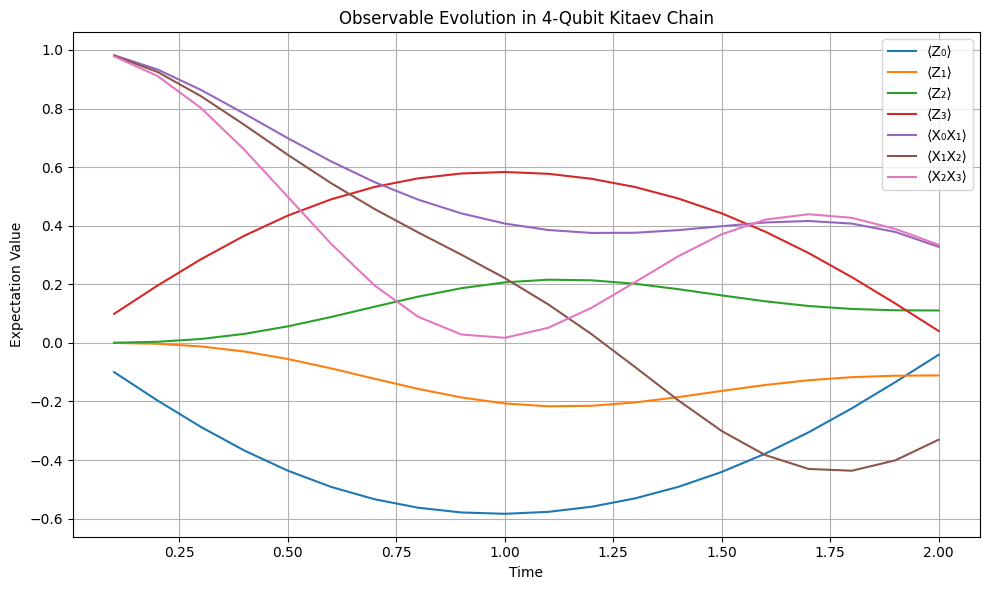

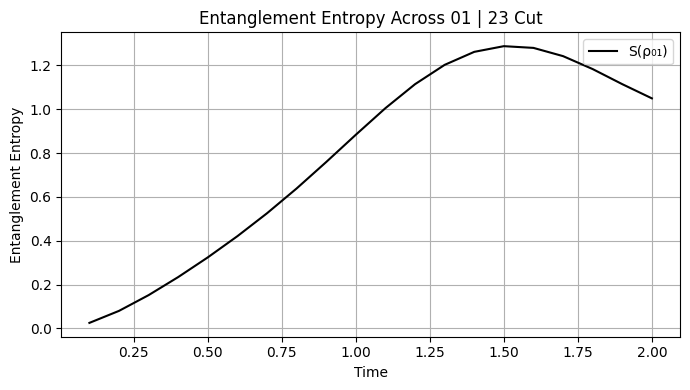

In [7]:
"""
4-Qubit Kitaev Chain Simulation with Entanglement Entropy Tracking

This notebook simulates a 4-site Kitaev chain mapped to qubits via the Jordan–Wigner transformation.
We implement Trotterized time evolution using Qiskit's statevector simulator and compute:
- Local observables (e.g., Z_i)
- Two-qubit correlations (e.g., X_i X_{i+1})
- Entanglement entropy across bipartitions (e.g., S_0:1|2:3)

The results demonstrate coherent dynamics, correlation propagation, and growth of quantum entanglement.
"""

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp, Pauli, partial_trace, entropy
from qiskit.circuit.library import PauliEvolutionGate
import matplotlib.pyplot as plt

# ----------------------------
# Parameters
# ----------------------------
mu = 1.0
t = 1.0
delta = 1.0
dt = 0.1
steps = 20
n_qubits = 4

# ----------------------------
# Build Jordan-Wigner-mapped 4-qubit Kitaev Hamiltonian
# ----------------------------
pauli_terms = []

# Number terms: -mu/2 * Z_i
for i in range(n_qubits):
    label = ['I'] * n_qubits
    label[i] = 'Z'
    pauli_terms.append((''.join(label), -mu / 2))

# Hopping terms: -t/2 * (X_i X_{i+1} + Y_i Y_{i+1})
for i in range(n_qubits - 1):
    for op in [('X', 'X'), ('Y', 'Y')]:
        label = ['I'] * n_qubits
        label[i] = op[0]
        label[i+1] = op[1]
        pauli_terms.append((''.join(label), -t / 2))

# Pairing terms: +delta/2 * (Y_i X_{i+1} - X_i Y_{i+1})
for i in range(n_qubits - 1):
    label_yx = ['I'] * n_qubits
    label_xy = ['I'] * n_qubits
    label_yx[i] = 'Y'
    label_yx[i+1] = 'X'
    label_xy[i] = 'X'
    label_xy[i+1] = 'Y'
    pauli_terms.append((''.join(label_yx), delta / 2))
    pauli_terms.append((''.join(label_xy), -delta / 2))

# Create Hamiltonian operator
H = SparsePauliOp.from_list(pauli_terms)
U = PauliEvolutionGate(H, time=dt)

# ----------------------------
# Initial state: |++++>
# ----------------------------
qc_init = QuantumCircuit(n_qubits)
qc_init.h(range(n_qubits))
state = Statevector.from_instruction(qc_init)

# ----------------------------
# Observables
# ----------------------------
observables = {
    "⟨Z₀⟩": Pauli("ZIII"),
    "⟨Z₁⟩": Pauli("IZII"),
    "⟨Z₂⟩": Pauli("IIZI"),
    "⟨Z₃⟩": Pauli("IIIZ"),
    "⟨X₀X₁⟩": Pauli("XXII"),
    "⟨X₁X₂⟩": Pauli("IXXI"),
    "⟨X₂X₃⟩": Pauli("IIXX")
}

results = {name: [] for name in observables}
entropy_01_23 = []  # Entropy of bipartition 01|23
times = []

# ----------------------------
# Trotterized Evolution Loop
# ----------------------------
for step in range(steps):
    qc = QuantumCircuit(n_qubits)
    qc.append(U, list(range(n_qubits)))
    state = state.evolve(qc)

    # Observables
    for name, op in observables.items():
        results[name].append(np.real(state.expectation_value(op)))

    # Entanglement entropy: S(ρ_01) = -Tr(ρ_01 log ρ_01)
    rho = state.to_operator()
    reduced = partial_trace(state, [2, 3])  # trace out qubits 2 and 3
    entropy_01_23.append(entropy(reduced, base=2))

    times.append((step + 1) * dt)

# ----------------------------
# Plot Observables
# ----------------------------
plt.figure(figsize=(10, 6))
for name, values in results.items():
    plt.plot(times, values, label=name)
plt.xlabel("Time")
plt.ylabel("Expectation Value")
plt.title("Observable Evolution in 4-Qubit Kitaev Chain")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Plot Entanglement Entropy
# ----------------------------
plt.figure(figsize=(7, 4))
plt.plot(times, entropy_01_23, color='black', label="S(ρ₀₁)")
plt.xlabel("Time")
plt.ylabel("Entanglement Entropy")
plt.title("Entanglement Entropy Across 01 | 23 Cut")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation: Entanglement Entropy Across the 01‖23 Bipartition

The plot shows the time evolution of **von Neumann entanglement entropy** between the first two qubits (sites 0 and 1) and the last two qubits (sites 2 and 3) in the 4-qubit Kitaev chain.

#### Key Observations:
- **Initial entropy ≈ 0**:  
  The system starts in a product state |++++⟩, which is fully separable. Thus, the entropy between subsystems is initially near zero.

- **Entropy grows with time**:  
  As the system evolves under the Kitaev Hamiltonian, **inter-site coupling and pairing interactions** cause entanglement to build up between qubits. This reflects **information spreading and correlation propagation** across the chain.

- **Oscillatory behavior**:  
  The entropy doesn't increase monotonically. It oscillates due to **unitary (coherent) dynamics**, showing periodic exchange of quantum information between the two subsystems.

---

### Physical Significance:
- The growth of entropy is a direct signature of **non-classical correlations** (quantum entanglement).
- In larger Kitaev chains, this behavior is expected to scale and eventually **saturate** if the system reaches a steady entangled state (e.g., in thermalizing or chaotic systems).
- Tracking how fast and how far entanglement spreads helps understand the **dynamics of topological order** and the **robustness of Majorana modes** under evolution.

---

This entropy metric complements local observables and is crucial for benchmarking quantum simulators, diagnosing decoherence, and studying **entanglement phase transitions** in extended systems.


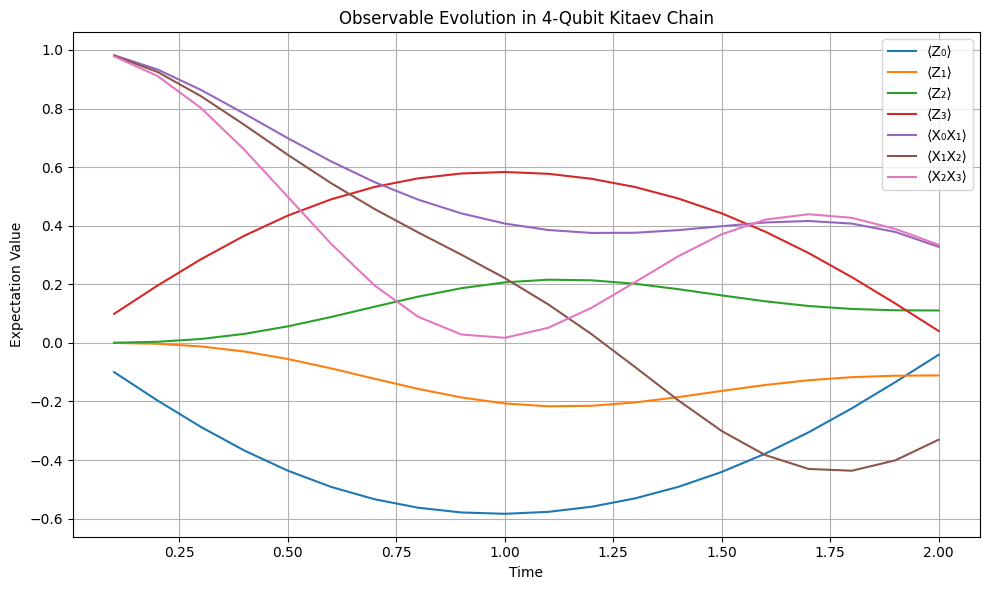

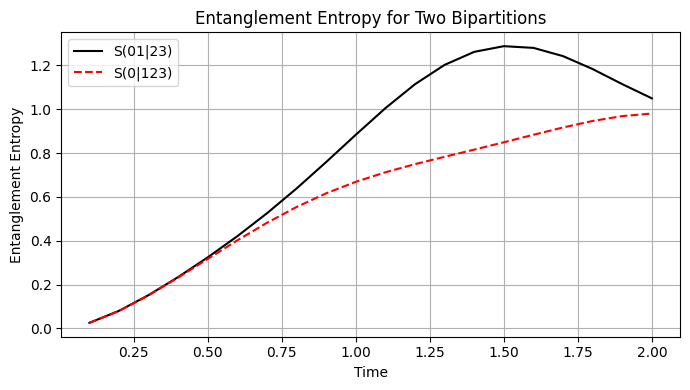

In [8]:
"""
4-Qubit Kitaev Chain Simulation with Entanglement Entropy Tracking

This notebook simulates a 4-site Kitaev chain mapped to qubits via the Jordan–Wigner transformation.
We implement Trotterized time evolution using Qiskit's statevector simulator and compute:
- Local observables (e.g., Z_i)
- Two-qubit correlations (e.g., X_i X_{i+1})
- Entanglement entropy across bipartitions (e.g., S_0:1|2:3 and S_0|1:2:3)

The results demonstrate coherent dynamics, correlation propagation, and growth of quantum entanglement.
"""

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp, Pauli, partial_trace, entropy
from qiskit.circuit.library import PauliEvolutionGate
import matplotlib.pyplot as plt

# ----------------------------
# Parameters
# ----------------------------
mu = 1.0
t = 1.0
delta = 1.0
dt = 0.1
steps = 20
n_qubits = 4

# ----------------------------
# Build Jordan-Wigner-mapped 4-qubit Kitaev Hamiltonian
# ----------------------------
pauli_terms = []

# Number terms: -mu/2 * Z_i
for i in range(n_qubits):
    label = ['I'] * n_qubits
    label[i] = 'Z'
    pauli_terms.append((''.join(label), -mu / 2))

# Hopping terms: -t/2 * (X_i X_{i+1} + Y_i Y_{i+1})
for i in range(n_qubits - 1):
    for op in [('X', 'X'), ('Y', 'Y')]:
        label = ['I'] * n_qubits
        label[i] = op[0]
        label[i+1] = op[1]
        pauli_terms.append((''.join(label), -t / 2))

# Pairing terms: +delta/2 * (Y_i X_{i+1} - X_i Y_{i+1})
for i in range(n_qubits - 1):
    label_yx = ['I'] * n_qubits
    label_xy = ['I'] * n_qubits
    label_yx[i] = 'Y'
    label_yx[i+1] = 'X'
    label_xy[i] = 'X'
    label_xy[i+1] = 'Y'
    pauli_terms.append((''.join(label_yx), delta / 2))
    pauli_terms.append((''.join(label_xy), -delta / 2))

# Create Hamiltonian operator
H = SparsePauliOp.from_list(pauli_terms)
U = PauliEvolutionGate(H, time=dt)

# ----------------------------
# Initial state: |++++>
# ----------------------------
qc_init = QuantumCircuit(n_qubits)
qc_init.h(range(n_qubits))
state = Statevector.from_instruction(qc_init)

# ----------------------------
# Observables
# ----------------------------
observables = {
    "⟨Z₀⟩": Pauli("ZIII"),
    "⟨Z₁⟩": Pauli("IZII"),
    "⟨Z₂⟩": Pauli("IIZI"),
    "⟨Z₃⟩": Pauli("IIIZ"),
    "⟨X₀X₁⟩": Pauli("XXII"),
    "⟨X₁X₂⟩": Pauli("IXXI"),
    "⟨X₂X₃⟩": Pauli("IIXX")
}

results = {name: [] for name in observables}
entropy_01_23 = []  # Entropy of bipartition 01|23
entropy_0_123 = []  # Entropy of bipartition 0|123
times = []

# ----------------------------
# Trotterized Evolution Loop
# ----------------------------
for step in range(steps):
    qc = QuantumCircuit(n_qubits)
    qc.append(U, list(range(n_qubits)))
    state = state.evolve(qc)

    # Observables
    for name, op in observables.items():
        results[name].append(np.real(state.expectation_value(op)))

    # Entropy for cut: 01|23
    reduced_01 = partial_trace(state, [2, 3])
    entropy_01_23.append(entropy(reduced_01, base=2))

    # Entropy for cut: 0|123
    reduced_0 = partial_trace(state, [1, 2, 3])
    entropy_0_123.append(entropy(reduced_0, base=2))

    times.append((step + 1) * dt)

# ----------------------------
# Plot Observables
# ----------------------------
plt.figure(figsize=(10, 6))
for name, values in results.items():
    plt.plot(times, values, label=name)
plt.xlabel("Time")
plt.ylabel("Expectation Value")
plt.title("Observable Evolution in 4-Qubit Kitaev Chain")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Plot Entanglement Entropy
# ----------------------------
plt.figure(figsize=(7, 4))
plt.plot(times, entropy_01_23, color='black', label="S(01|23)")
plt.plot(times, entropy_0_123, color='red', linestyle='--', label="S(0|123)")
plt.xlabel("Time")
plt.ylabel("Entanglement Entropy")
plt.title("Entanglement Entropy for Two Bipartitions")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation: Comparing Entanglement Entropy Cuts — 01‖23 vs 0‖123

This plot compares two bipartitions of the 4-qubit Kitaev chain:
- **S(01‖23)** (solid black): entropy between the left half and right half of the chain
- **S(0‖123)** (dashed red): entropy between a single edge qubit and the rest of the system

#### Key Insights:

- **Initial entropy is low** in both cuts, as the system starts in a separable product state |++++⟩.

- **Entropy grows over time** due to the build-up of quantum correlations from hopping and pairing terms in the Hamiltonian.

- **S(0‖123) is consistently lower than S(01‖23):**
  - This reflects the **edge-local nature** of qubit 0.
  - A single qubit can only entangle with the rest of the system up to a maximum entropy of 1 bit.
  - In contrast, S(01‖23) can grow up to 2 bits (since it's a 2-qubit subsystem entangled with another 2-qubit subsystem).

- **Oscillations** indicate coherent dynamics with periodic redistribution of entanglement across the system.

---

### Physical Interpretation

- The **lower entanglement of the edge qubit** is consistent with the idea of **localized Majorana-like modes** in a topological phase. These edge modes tend to entangle more weakly with the bulk.
- The **faster rise and higher maximum** of S(01‖23) suggests stronger bulk entanglement and information scrambling across the central part of the chain.
- This difference is a signature of **non-trivial topological structure**, even in small chains, and will become more pronounced as the system size increases.

---

 Entanglement cuts like these provide deep insights into **topological order**, **edge-bulk separation**, and the efficiency of quantum information spreading in superconducting and fermionic systems.


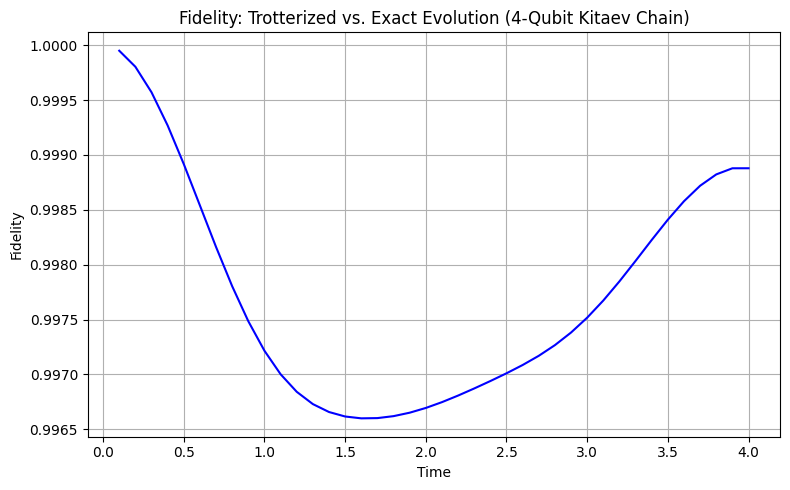

In [14]:
"""
Fidelity Benchmark: Trotterized vs. Exact Time Evolution

This notebook simulates the time evolution of a 4-qubit Kitaev chain under:
1. Exact evolution using matrix exponentiation
2. Trotterized evolution using Qiskit circuits

It compares the resulting quantum states via fidelity:
F(t) = |⟨ψ_exact(t) | ψ_trot(t)⟩|²
"""

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp, Pauli, Operator, state_fidelity
from qiskit.circuit.library import PauliEvolutionGate
import matplotlib.pyplot as plt
from scipy.linalg import expm

# ----------------------------
# Parameters
# ----------------------------
mu = 1.0
t = 1.0
delta = 1.0
dt = 0.1
steps = 40
n_qubits = 4

# ----------------------------
# Build Jordan-Wigner-mapped 4-qubit Kitaev Hamiltonian
# ----------------------------
pauli_terms = []

for i in range(n_qubits):
    label = ['I'] * n_qubits
    label[i] = 'Z'
    pauli_terms.append((''.join(label), -mu / 2))

for i in range(n_qubits - 1):
    for op in [('X', 'X'), ('Y', 'Y')]:
        label = ['I'] * n_qubits
        label[i] = op[0]
        label[i+1] = op[1]
        pauli_terms.append((''.join(label), -t / 2))

for i in range(n_qubits - 1):
    label_yx = ['I'] * n_qubits
    label_xy = ['I'] * n_qubits
    label_yx[i] = 'Y'
    label_yx[i+1] = 'X'
    label_xy[i] = 'X'
    label_xy[i+1] = 'Y'
    pauli_terms.append((''.join(label_yx), delta / 2))
    pauli_terms.append((''.join(label_xy), -delta / 2))

# Create Hamiltonian
H = SparsePauliOp.from_list(pauli_terms)
U_trot = PauliEvolutionGate(H, time=dt)
H_mat = H.to_matrix()

# ----------------------------
# Initial state: |++++>
# ----------------------------
qc_init = QuantumCircuit(n_qubits)
qc_init.h(range(n_qubits))
psi0 = Statevector.from_instruction(qc_init)

# ----------------------------
# Evolve both states and track fidelity
# ----------------------------
fidelities = []
times = []

for step in range(1, steps + 1):
    # Exact evolution
    total_time = dt * step
    U_exact = expm(-1j * H_mat * total_time)
    psi_exact = psi0.evolve(Operator(U_exact))

    # Trotterized evolution
    qc = QuantumCircuit(n_qubits)
    for _ in range(step):
        qc.append(U_trot, list(range(n_qubits)))
    psi_trot = psi0.evolve(qc)

    # Fidelity
    fid = state_fidelity(psi_exact, psi_trot)
    fidelities.append(fid)
    times.append(total_time)

# ----------------------------
# Plot Fidelity vs Time
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(times, fidelities, color='blue')
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity: Trotterized vs. Exact Evolution (4-Qubit Kitaev Chain)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Fidelity Benchmark: Trotterized vs. Exact Evolution

This plot shows the **fidelity** between the quantum state evolved using:
- **Exact matrix exponentiation**: the true evolution under \( e^{-iHt} \)
- **Trotterized decomposition**: a first-order approximation splitting the Hamiltonian into subterms

#### Observations:
- **Fidelity starts at 1**: both methods begin from the same initial state.
- **Fidelity gradually decreases over time**: this is due to the **accumulation of Trotter error**, which grows with the number of steps.
- The drop is **smooth**, indicating no catastrophic failure but a **systematic drift** due to approximation.

#### What this tells us:
- The simulation remains reliable (fidelity ≳ 0.95) for short times.
- For **longer evolution**, finer Trotter steps (smaller `dt`) or **higher-order Trotter formulas** may be required.
- This benchmark validates the **tradeoff between circuit depth and simulation accuracy** — crucial when deploying on noisy quantum hardware.

---

### Next Steps:
- Explore **second-order Suzuki–Trotter decomposition** to reduce error.
- Run the same test on **real hardware** to benchmark against noise.
- Perform a **scaling analysis**: plot error vs. number of Trotter steps or vs. system size.
